# Market Volatility Forecasting using GARCH models

In [135]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from scipy import stats

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [104]:
# Plotting options

sns.set(style="darkgrid", color_codes=True)

#### Download data from Yahoo Finance

In [7]:
df = yf.download("FTSEMIB.MI", end='2023-12-14')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-12-31,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000,0
1998-01-02,24914.000000,24914.000000,24914.000000,24914.000000,24914.000000,0
1998-01-05,25734.000000,25734.000000,25734.000000,25734.000000,25734.000000,0
1998-01-06,25734.000000,25734.000000,25734.000000,25734.000000,25734.000000,0
1998-01-07,25961.000000,25961.000000,25961.000000,25961.000000,25961.000000,0
...,...,...,...,...,...,...
2023-12-07,30297.000000,30343.000000,30053.000000,30122.000000,30122.000000,421882000
2023-12-08,30150.000000,30427.000000,30058.000000,30404.000000,30404.000000,315888900
2023-12-11,30418.000000,30470.000000,30303.000000,30427.000000,30427.000000,309967400


#### Calculate log returns

Log returns are calculated as follows:

$return_t = log(\frac{P_t}{P_{t-1}})$

In [108]:
returns = pd.Series(np.log(df['Adj Close']/df['Adj Close'].shift(1)), index = df.index).dropna()
returns 

Date
1998-01-02    0.020765
1998-01-05    0.032383
1998-01-06    0.000000
1998-01-07    0.008782
1998-01-08   -0.011078
                ...   
2023-12-07   -0.006750
2023-12-08    0.009318
2023-12-11    0.000756
2023-12-12   -0.002797
2023-12-13    0.001092
Name: Adj Close, Length: 6636, dtype: float64

#### Define plotting function for the time series

This function will be useful to take a look at a series' characteristics by looking at the QQ plot, ACF plot and PACF plot. 

In [129]:
def ts_plot(series : pd.Series, max_lags : int, title : str):

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot the series
    axs[0, 0].plot(series)
    axs[0, 0].set_title('Series')

    # QQPLOT
    qqplot(series, ax = axs[0, 1], line='s')
    axs[0, 1].set_title('QQ plot')

    # ACF PLOT
    plot_acf(series, lags=max_lags, ax = axs[1, 0], zero=False) # zero = False to not include lag 0
    axs[1, 0].set_title('Autocorrelation plot')
    axs[1, 0].set_xlabel('Lag')

    # PACF PLOT
    plot_pacf(series, lags=max_lags, ax = axs[1, 1], zero=False)
    axs[1, 1].set_title('Partial Autocorrelation plot')
    axs[1, 1].set_xlabel('Lag')

    fig.suptitle(title, fontsize=20)
    axs[1, 0].autoscale()
    axs[1, 1].autoscale()

Before proceeding to model the returns volatility using GARCH models, we shall discuss some characteristics of the returns and of the volatily of returns.

## Analysis of FTSE MIB returns, distribution and anomalies

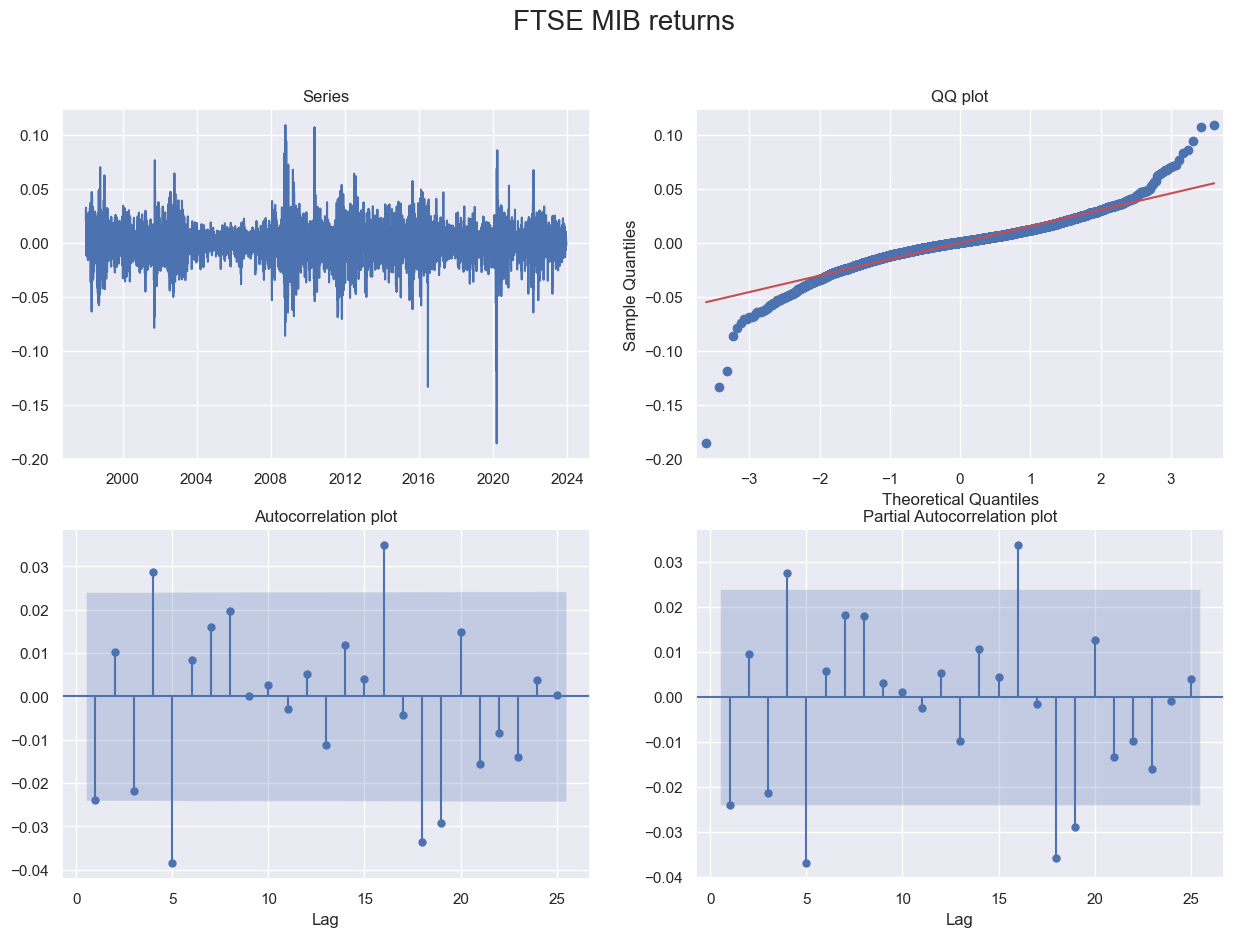

In [132]:
ts_plot(returns, 25, 'FTSE MIB returns')

As we can see, no serial correlation seems to appear in the returns. Even if there are some significant lags that exhibit correlation in both the ACF and the PACF, the continuous oscillation of the correlation are tipycal of a stationary series and indicate some form of independence in the observations. 

However, we can't stop our analysis here. To ensure that this is an independent series, or rather to test that it is not, we may recall the fact that an independent series is one in which transformations of the series are themselves independent. 

So let's now examine the squared of the returns in the following plot. Squared of returns are basically an aproximation (an unbiased estimate) of the volatility (if one assumes that the mean of the returns is zero, or returns are normally distributed). Comparing the following ACF and PACF plots with the previous one, the populated presence of significative positive correlations at different time lags suggest that the log returns are indeed serially uncorrelated but dependent. And <u>hence, some kind of non dependence in the returns exist, as shown by the squared returns</u>.

ARCH models will attempt to capture such dependence in the return series.

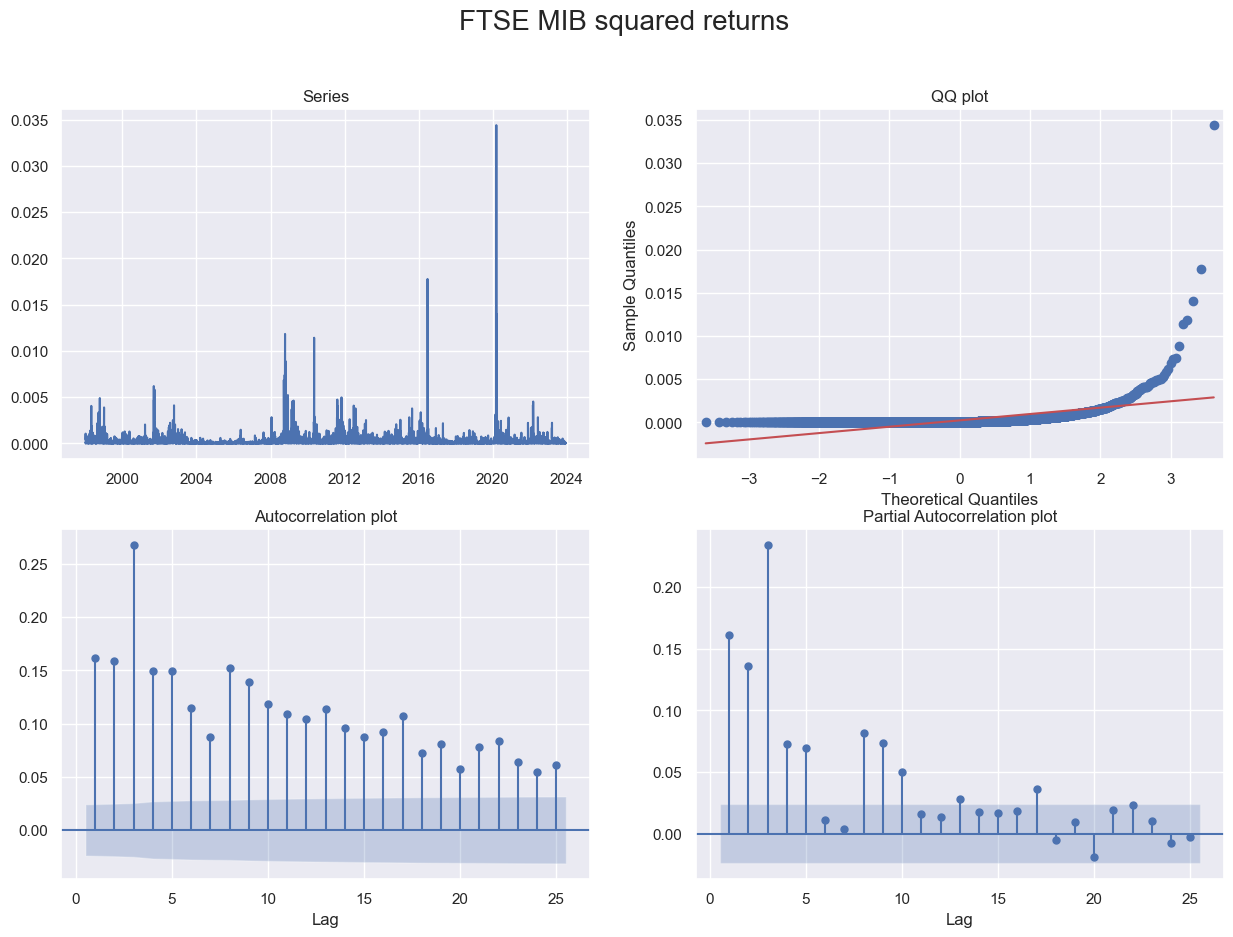

In [134]:
ts_plot(returns**2, 25, 'FTSE MIB squared returns')

#### Ljung-Box test 

Another way to check the presence of autocorrelation in the data is using the Ljung Box test statistic, for which:

- $H_0$ : The data are independently distributed; No Autocorrelation
- $H_1$ : The data are not independently distributed; they exhibit serial correlation.

In [146]:
sm.stats.acorr_ljungbox(returns**2, lags=None, auto_lag=True)

,lb_stat,lb_pvalue
1,173.136456,1.528160e-39
2,340.223471,1.322550e-74
3,816.253334,1.291886e-176
4,963.696453,2.628964e-207
5,1111.770765,3.776234e-238
...,...,...
115,3062.561855,0.000000e+00
116,3069.314044,0.000000e+00
117,3073.568958,0.000000e+00
118,3076.081981,0.000000e+00


In [148]:
# check if any lag pvalue is statistically not significant
(sm.stats.acorr_ljungbox(returns**2, lags=None, auto_lag=True)['lb_pvalue'] > 0.05).sum() 

0

Since all p-values are smaller than 0.05 we reject the null hypotheses and can conclude that there is AUTOCORRELATION in the variance of the data (in the squared returns).

#### Returns Distribution

Let's now focus on the distribution of the returns and observe possible anomalies.

Text(0.5, 1.0, '2nd anomaly: higher spike of FTSE returns distribution')

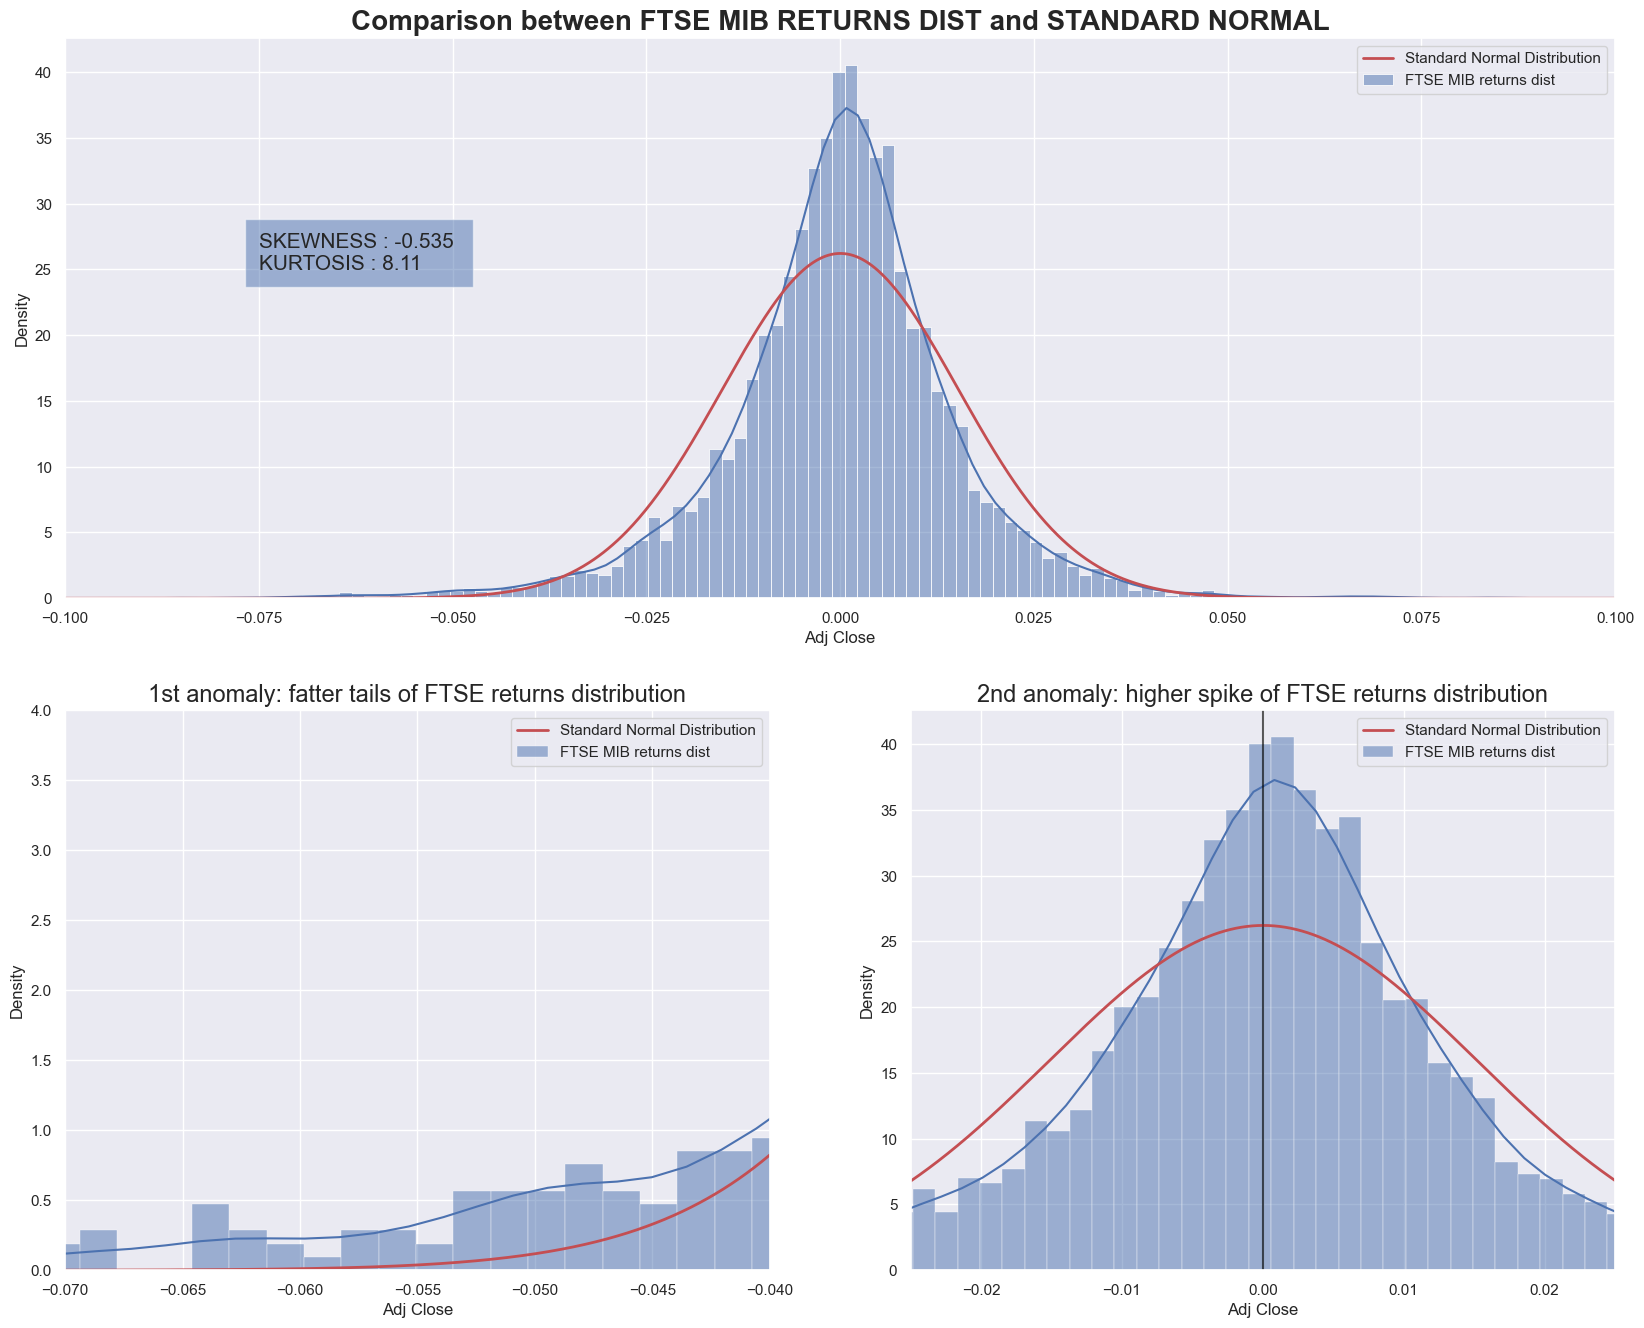

In [154]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :])
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])


sns.histplot(returns, stat='density', kde=True, label='FTSE MIB returns dist')
ax.set_xlim([-0.10, 0.10])
x = np.linspace(-0.1, 0.1, 1000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
ax.plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
ax.legend()
ax.set_title('Comparison between FTSE MIB RETURNS DIST and STANDARD NORMAL', fontsize=20, fontweight='bold')
ax.text(-0.075, 25, f'SKEWNESS : {returns.skew():.3} \nKURTOSIS : {returns.kurtosis():.3}', style='normal',
        bbox={'alpha': 0.5, 'pad': 10}, fontsize=15)

# Lower-left plot (focus on left fat tail)
sns.histplot(returns, stat='density', kde=True, ax = axs[1, 0], label='FTSE MIB returns dist')
axs[1, 0].set_xlim([-0.07, -0.04])
axs[1, 0].set_ylim([0, 4])
x = np.linspace(-0.07, -0.04, 10000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
axs[1, 0].plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
axs[1, 0].legend()
axs[1, 0].set_title('1st anomaly: fatter tails of FTSE returns distribution', fontsize=17)


# Lower-right plot (focus on the central leptokurticity)
sns.histplot(returns, stat='density', kde=True, ax = axs[1, 1], label='FTSE MIB returns dist')
axs[1, 1].set_xlim([-0.025, +0.025])
axs[1, 1].axvline(0, c='black', alpha=0.4)
x = np.linspace(-0.025, +0.025, 10000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
axs[1, 1].plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
axs[1, 1].axvline(0, c='black', alpha=0.4)
axs[1, 1].legend()
axs[1, 1].set_title('2nd anomaly: higher spike of FTSE returns distribution', fontsize=17)



In [111]:
print('Skewness:', returns.skew(), '\nKurtosis:', returns.kurtosis())

Skewness: -0.5352948261229868 
Kurtosis: 8.11337342982336


As we can observe from the previous plot and from the printe characteristichs of the distribution, there two main observations we can derive:

1) Kurtosis. The distribution of returns of the FTSE MIB present a clear leptokurticity, the high positive value for the kurtosis (+8.1) and the spikes in the central part of the distribution that we can visualize from the previous plot, confirms a typical behaviour in financial returns of the equity market. In addition, leptokurticity reflects another charactertics in the distribution. The so called *fatter tails* (as shown in the lower left plot of the previous figure) implies that returns have a higher probability of extreme events (both positive and negative) compared to a normal distribution. This means that large price movements, both in the positive and negative tail, are more probable that what would be expected under the normal distribution assumption.  

2) Skewness. The distribution of the returns presents a negative skewness. When compared to a normal distribution, this skewness suggests that the distribution of returns has a longer left tail. This is reflected in the fact that there is a higher probability of large negative returns comapred to large positive returns. This characeristic is important in the context of risk management, and analysing it can help the banks and financial institutions in choosing the right strategies to counter extreme negative events. 


This two characertistics are really important, and enter in the discussion of the *stylized facts of financial returns*. The other two remaining *facts* are the following:

> 3) *The presence of a difference in the behavior of short term returns (such as daily) and long term returns (such as monthly or quarterly)*
>
> 4) *The tendency of extreme returns to happen in clusters, very closely in time (volatility clustering)*

Naturally, this common characteristics have to be correctly modeled in order to capture the anomalies in the financial returns:

> *To model the characteristics of observed return distributions, approaches generally fall into one of three categories:*
> 1. *Assume that returns have stable distributions of infinite variance.*
> 2. *Assume that returns have distributions that are more fat-tailed and/or skewed than the normal distribution.*
> 3. *Assume that the distributions of returns are normal at each instant of time, but look fat tailed due to fluctuations in the variance(volatility) of these distributions. Incorporate the fluctuations in the volatility using ARCH/GARCH or other models.* 


        Ref: Portfolio Construction and Analytics, Frank J. Fabozzi, Wiley (2016), p.78

In the following notebook we are going to focus on the third assumption, by trying to model the fluctuations (and clusters) of the returns volatility, implementing various GARCH and GARCH derived models. 


## Volatility Clustering and Market Regimes

After dealing with the main returns anomalies, there is still a second issue that we've just introduced: volatility clustering. 

A visual inspection of the returns series should give us a first glance at this phenomenom. In the following figure, the returns series is plotted with a 21 days rolling volatility. 

(-0.1, 0.1)

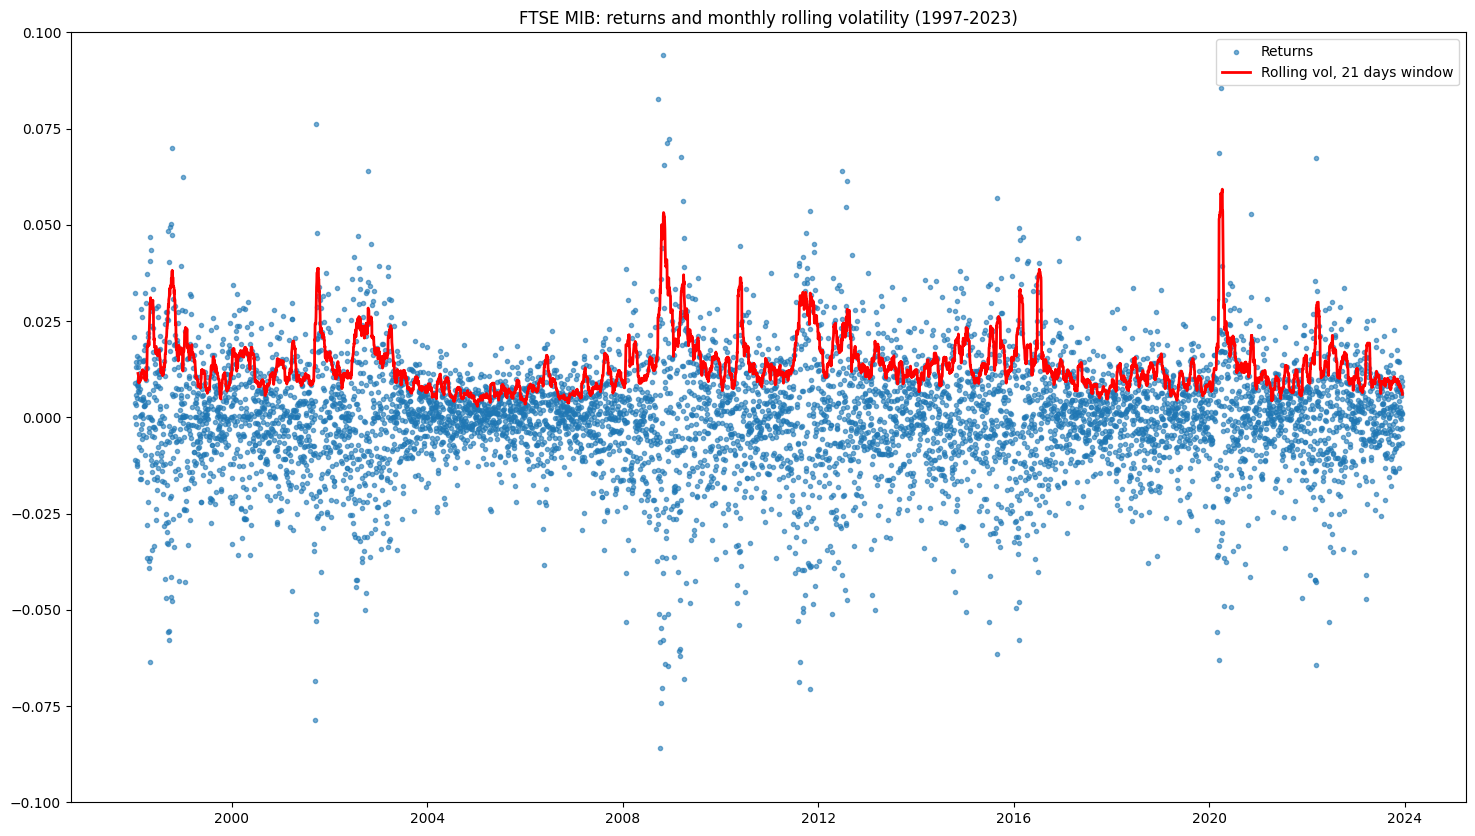

In [9]:
plt.figure(figsize=(18, 10))
plt.scatter(returns.index, returns, marker='.', label='Returns', alpha=0.6)

onem_vol = pd.Series(returns.rolling(window=21).std(), index = returns.index)
plt.plot(onem_vol, color='red', label='Rolling vol, 21 days window', linewidth=2)

plt.title('FTSE MIB: returns and monthly rolling volatility (1997-2023)')
plt.legend()
plt.ylim([-0.1, +0.1])

#### Volatility clustering

As we can see from the previous plot, it's clear how there are alternating periods in the behaviour of the returns (and its volatility). There is the persistence of periods in which the oscillations of the returns are more pronounced and cause a persistent increase in the volatility of the market. On the contrary, there are periods in which the market returns are more stable and tend to be associated with prolonged phases of constant volatility. 

These two arguments form the basis of the **volatility clustering** phenomenom. 

> Volatility clustering refers to the observation that large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes. This phenomenom led during the 80s the development of new models that could be sensible and robust to this behaviour in the volatility: the ARCH and GARCH family of models. 

#### Market regimes

As we have understood, this periods of concentrated high volatility are tipycal of more general trends in the market: market regimes. But how we can observe these regimes? The following part of the notebook will try to showcase the presence of different regimes in the series of FTSE MIB by leveraging an unsupervised learning technique, KMEANS. 

### KMeans visualization of the Volatility clusters

In [10]:
from sklearn.cluster import KMeans
# let's recreate the series of rolling volatilities for 90 days (~3 months) days and annualize it 
x = np.sqrt(251) * pd.Series(returns.rolling(window=90).std().dropna())
x = x.to_frame()
x.rename(columns = {'Adj Close' : '90 days Rolling Vol'}, inplace=True) #change column name
x

,90 days Rolling Vol
Date,
1998-05-07,0.287886
1998-05-08,0.288404
1998-05-11,0.287192
1998-05-12,0.288669
1998-05-13,0.289694
...,...
2023-12-07,0.139079
2023-12-08,0.138854
2023-12-11,0.138625


In [11]:
# This function will cluster the 90 days rolling volatilies into 3 groups (k defined = 3)

def kmeans_cluster(x, n_clusters : int):
    kmeans = KMeans(n_clusters = n_clusters, n_init='auto')
    kmeans.fit(x) #fit the Kmeans algo to the data

    clusters = kmeans.predict(x) #calculate the three clusters
    
    # 1) CREATE CLUSTER SERIES
    # The following series will store the cluster center of each element in the original series
    cluster_series = pd.Series(
        # creating a Series using list comprehension
        [
            round(kmeans.cluster_centers_[cluster_id, 0], 2)  #round the clusters centers to the 2nd decimals (just for clarity)
            for cluster_id in clusters
        ],
        index = x.index
    )

    # 2) CREATE CLUSTER DATAFRAME
    clustering_df = {}  #initialize an empty dictionary
    for cluster_id in range(n_clusters):
        # Extract the aproximated vol level of the cluster center (for each cluster)
        volatility_level = round(kmeans.cluster_centers_[cluster_id, 0], 2)  

        # For each cluster, store a boolean indicator for the observations that fall within the cluster 
        # -> the df is going to be a 3 column dataframe with each column referred to a cluster 
        # -> an observation in a specific row (time ordered series) will have TRUE(=1) for a specific column only if part of the relative cluster
        clustering_df[f'Cluster {volatility_level:.3}'] = (clusters == cluster_id).astype(float)
                                                                                # astype used to convert boolean in numeric
    
    clustering_df = pd.DataFrame(clustering_df, index=x.index) # convert list in a df
    clustering_df = clustering_df[sorted(clustering_df.columns)] # sort the columns of the df
    
    return clustering_df, cluster_series

1) `CREATE CLUSTER SERIES` 
    This piece of code is creating a series (with the same dimension as the x one), in which each element have the cluster center reference. For each day, the value will indicate the cluster membership (it will indicate the center of the cluster for which the obsevation is part of).

2) `CREATE CLUSTER DATAFRAME`
    This following part of the function is more difficult. Its main purpose it's extracting a dataframe in the format of a one hot encoding. The dataframe will have as many columns as the **k** defined at the beginning, and every element in the series will have a value = 1 if it belongs to a specific cluster, a specific column. 

In [12]:
KM_cluster_df, KM_cluster_series = kmeans_cluster(x, 3)
KM_cluster_df

,Cluster 0.15,Cluster 0.24,Cluster 0.39
Date,,,
1998-05-07,0.0,1.0,0.0
1998-05-08,0.0,1.0,0.0
1998-05-11,0.0,1.0,0.0
1998-05-12,0.0,1.0,0.0
1998-05-13,0.0,1.0,0.0
...,...,...,...
2023-12-07,1.0,0.0,0.0
2023-12-08,1.0,0.0,0.0
2023-12-11,1.0,0.0,0.0


In [147]:
KM_cluster_series[:5] #the value related to each date is the cluster center for which the day is part of

Date
1998-05-07    0.24
1998-05-08    0.24
1998-05-11    0.24
1998-05-12    0.24
1998-05-13    0.24
dtype: float64

#### Volatility clusters and 3 months rolling volatility

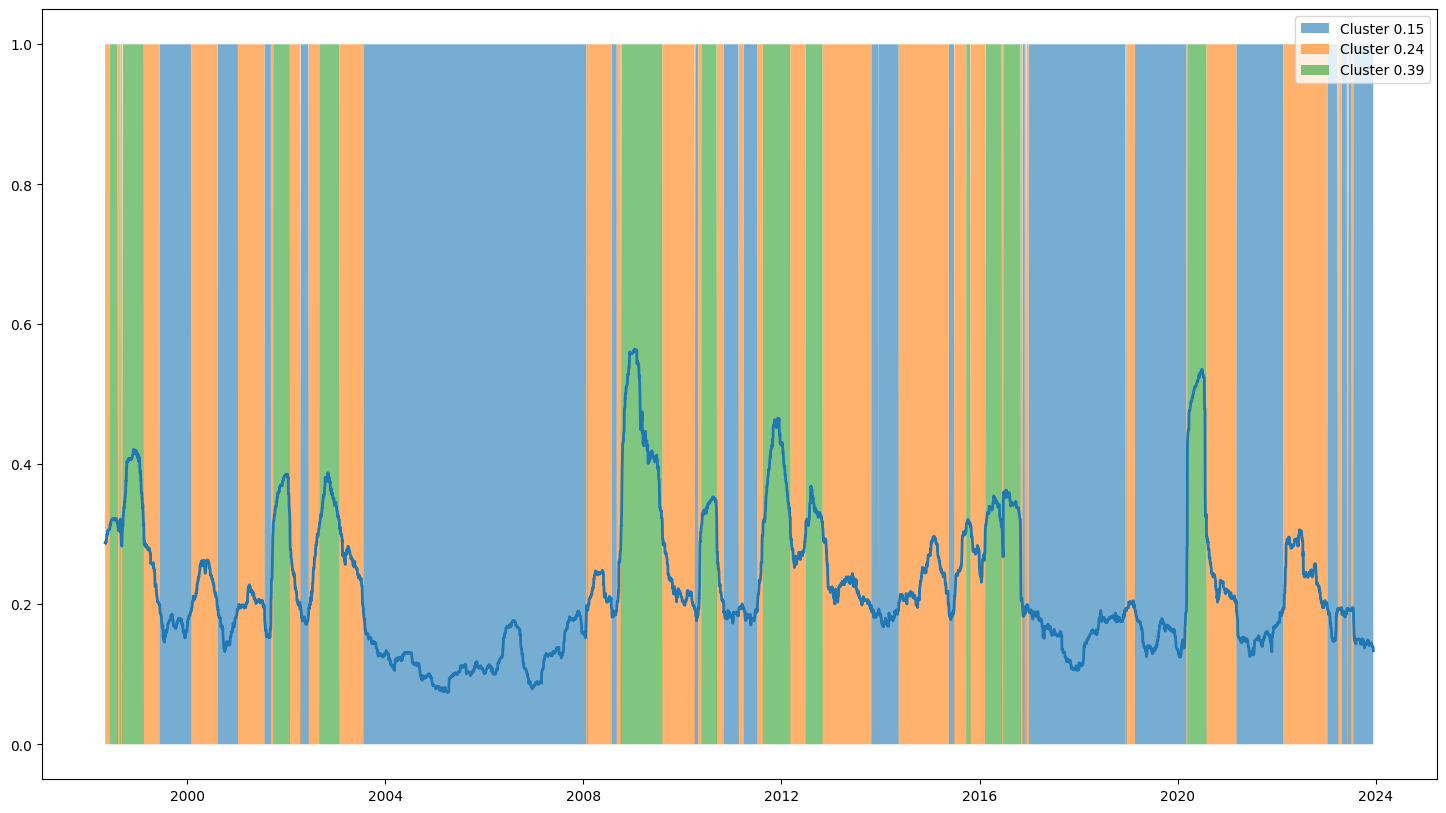

In [13]:
plt.figure(figsize=(18, 10))

for col in KM_cluster_df.columns:
    plt.fill_between(KM_cluster_df[col].index, 0, KM_cluster_df[col], alpha=0.6, label=col)

plt.plot(x, linewidth = 2)
plt.legend()

#### Volatility clusters and FTSE MIB PERFORMANCE

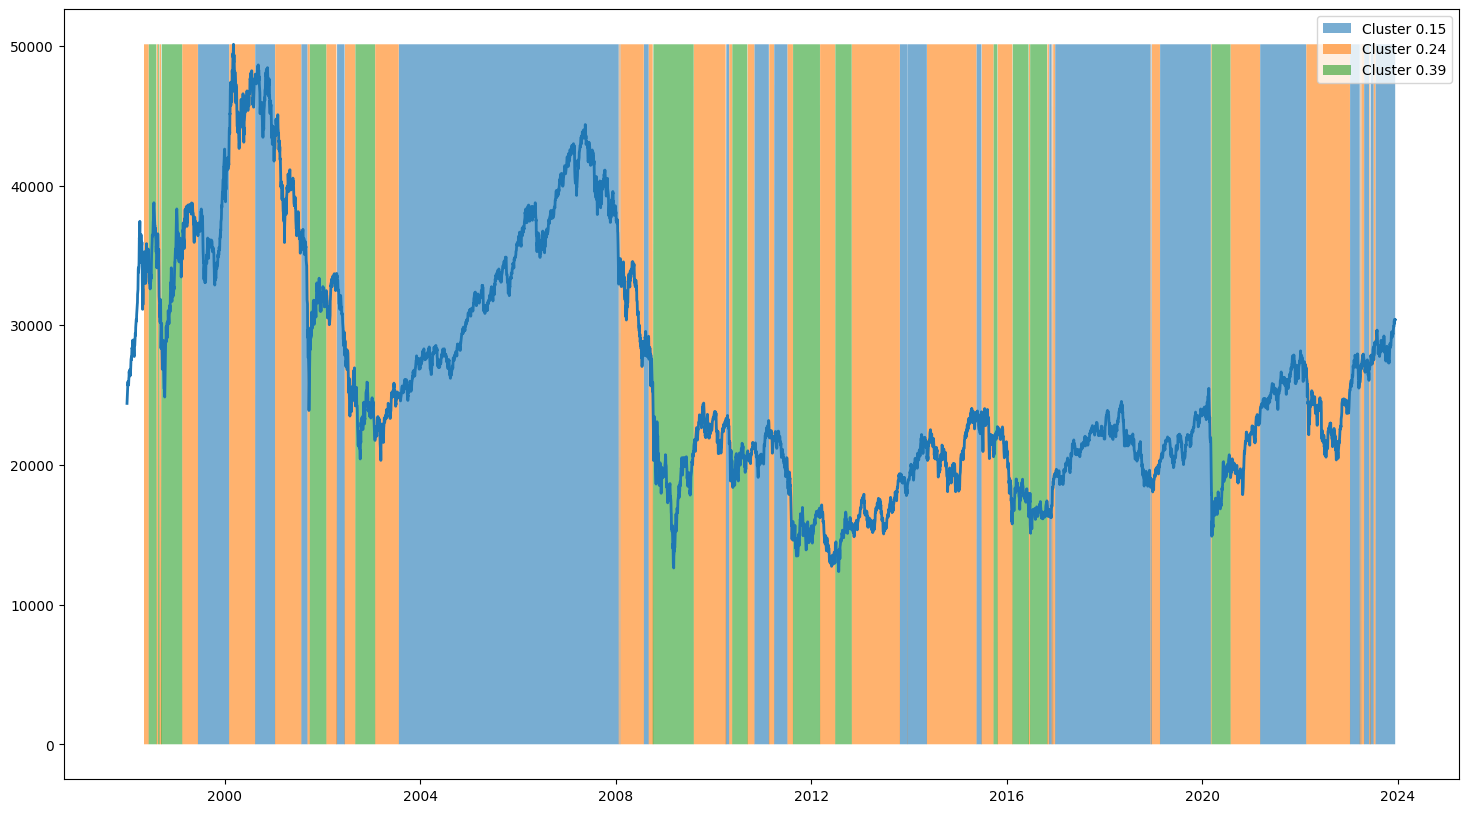

In [14]:
# Create a temporary dataframe for plotting purposes
temp = KM_cluster_df
for col in temp.columns:
    temp[col] = temp[col].apply(lambda x: x + max(df['Adj Close']) if x == 1 else x)


plt.figure(figsize=(18, 10))

for col in temp.columns:
    plt.fill_between(temp[col].index, 0, temp[col], alpha=0.6, label=col)

plt.plot(df['Adj Close'], linewidth = 2)
plt.legend()

# NOTE: graphically, the clusters are not calculated for the first 90 observations since 
# you can't calculate (and consequently cluster) the rolling volatility for the first 90 days

#### Volatility clusters and FTSE MIB PERFORMANCE (2008-2012)

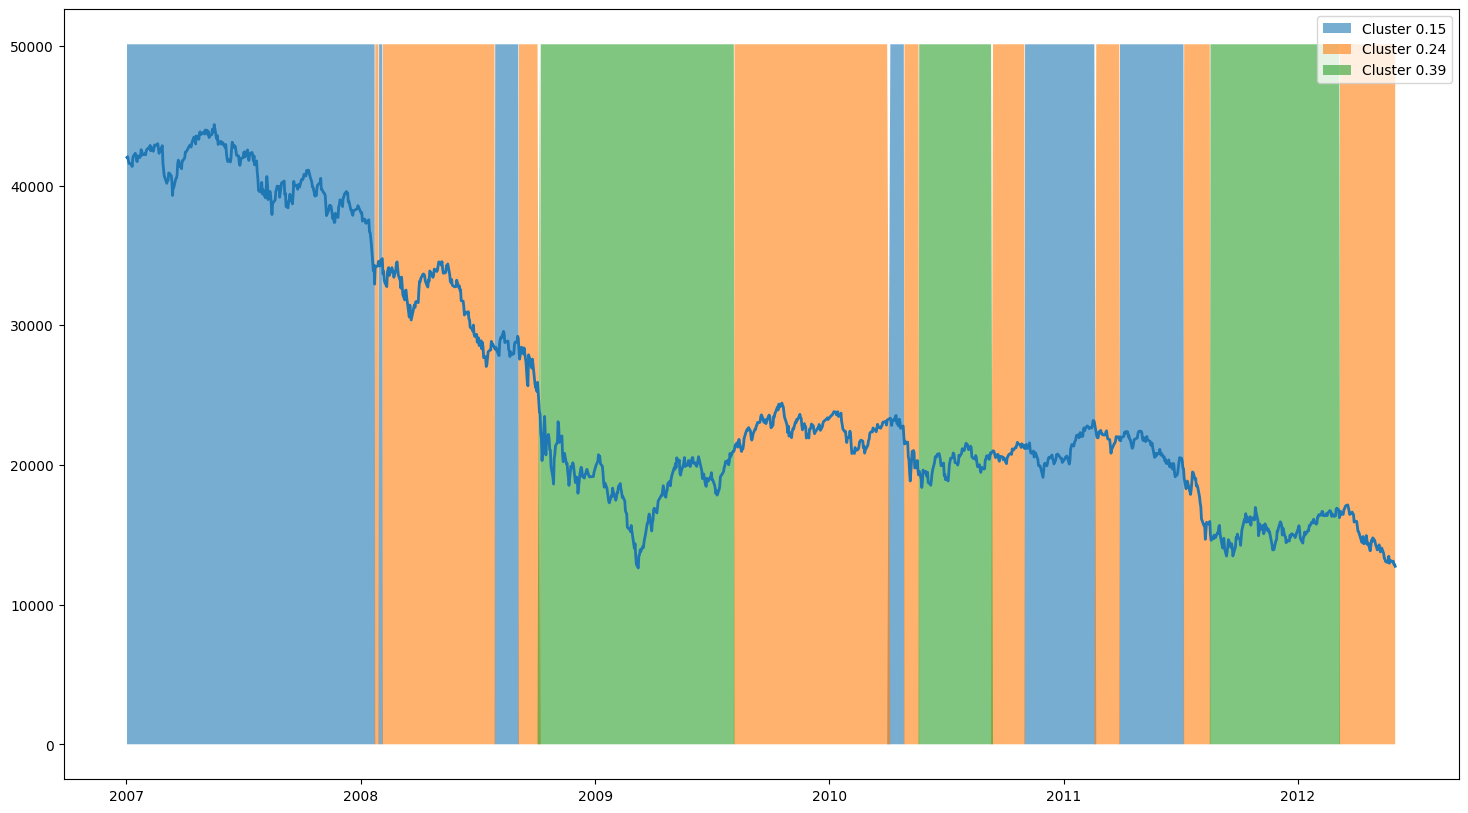

In [15]:
plt.figure(figsize=(18, 10))

for col in temp.columns:
    plt.fill_between(temp[col]['2007-01-01' : '2012-06-01'].index, 0, temp[col]['2007-01-01' : '2012-06-01'], alpha=0.6, label=col)

plt.plot(df['Adj Close']['2007-01-01' : '2012-06-01'], linewidth = 2)
plt.legend()

As we can see from the plot above, the cluster with higher vol (0.49) is the one that particularly characterized the 2008-2009 crisis (from the end of 2008 to mid of 2009) and part of the following debt crisis during 2011-2012. This periods are the  periods in which the markets is more stressed, there is a higher volatility, and returns are more probable in the extreme of the distribution (conditioned upon the specific market regimes we are considering). 
- The green areas belongs to the more volatile and riskier market regime, with higher vol and extreme positive or negative returns. 
- The orange are are part of a less riskier market regime. 
- The blue areas belongs to a market regime in which the volatility is the lower between the three. 

#### Volatility distributions conditioned on Market Regimes

In [16]:
kde_plot_df = pd.concat([x, KM_cluster_series.to_frame(name='Regimes')], axis=1)
kde_plot_df.head()

,90 days Rolling Vol,Regimes
Date,,
1998-05-07,0.287886,0.24
1998-05-08,0.288404,0.24
1998-05-11,0.287192,0.24
1998-05-12,0.288669,0.24
1998-05-13,0.289694,0.24


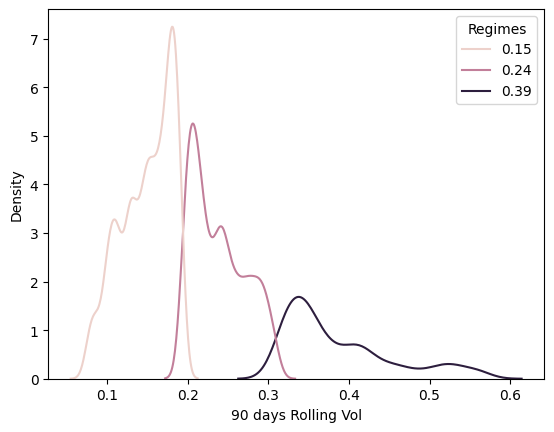

In [17]:
sns.kdeplot(kde_plot_df, x=kde_plot_df.columns[0], hue='Regimes')
plt.show()

This plot show the distribution of the volatily in the three different regimes we identified with the KMEANS. 

#### Returns distributions conditioned on Market Regimes

We can also look at the distribution of the returns under the three different regimes. 

In [18]:
#First, concatenate the cluster series (containing the cluster centers) and the return series
kde_plot_ret_df = pd.concat([returns, KM_cluster_series.to_frame(name='Regimes')], axis=1) 
kde_plot_ret_df.rename(columns = {'Adj Close' : 'Returns'}, inplace=True) 
kde_plot_ret_df.dropna(inplace=True)
kde_plot_ret_df.head()


,Returns,Regimes
Date,,
1998-05-07,-0.009774,0.24
1998-05-08,0.023603,0.24
1998-05-11,0.027720,0.24
1998-05-12,-0.014282,0.24
1998-05-13,-0.012302,0.24


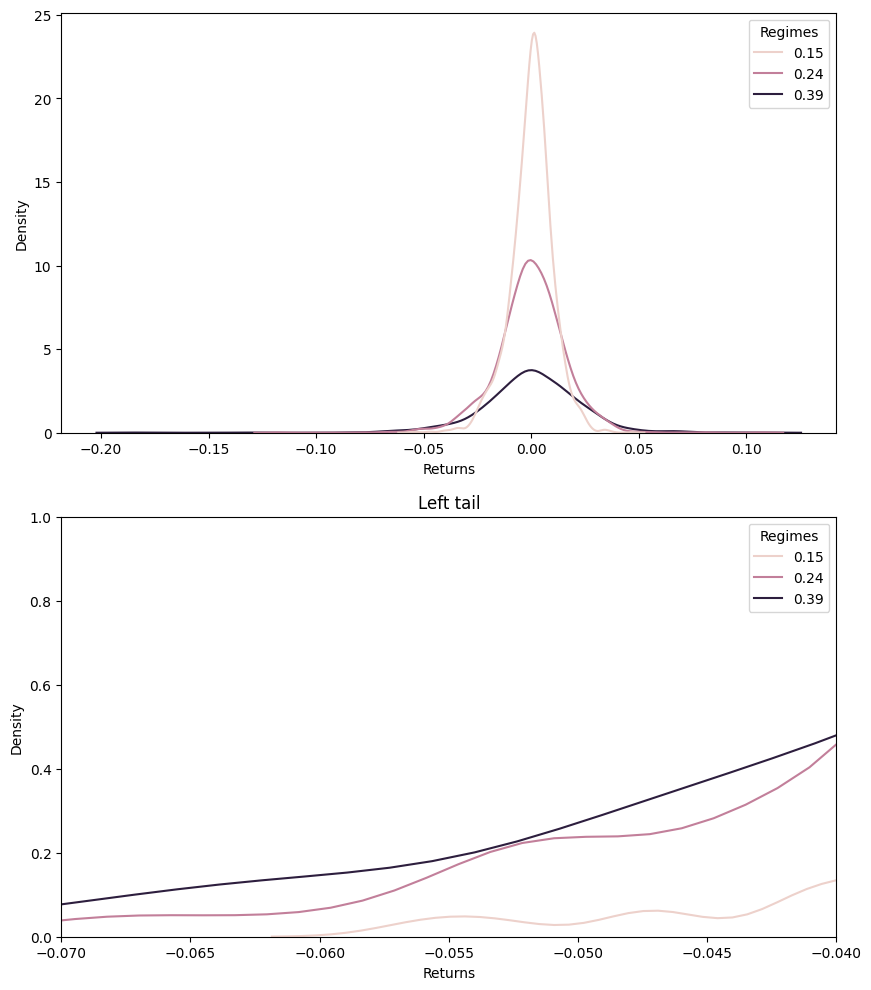

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))


sns.kdeplot(kde_plot_ret_df, x=kde_plot_ret_df.columns[0], hue='Regimes', ax=axs[0])

# Focus on the left tail
sns.kdeplot(kde_plot_ret_df, x=kde_plot_ret_df.columns[0], hue='Regimes', ax=axs[1])
axs[1].set_xlim([-0.07, -0.04])
axs[1].set_ylim([0, 1])
axs[1].set_title('Left tail')

plt.show()

As we can see in the black market regime (the one with higher volatility) the spike of the distribution is significantly lower, central returns (small movements in the market) are less probable to happen with respect to other market regimes. Instead, tails are clearly heavier and so extreme returns are more likely to happen. 

It's clear from this part of the analysis that a model capable of dealing with the returns anomalies and with the volatility eteroschedasticity is necessary. For this reasons, ARCH and GARCH model were developed and are going to be discussed shortly. 

## Data Preprocessing



#### Scale Returns

In order for the returns to be fed to the model, we should scale them by multiplying them by 100 (creating integer % values for the returns). 
This is a requirement of the `ARCH` library we are going to use to model GARCH models.


In [ ]:
returns *= 100
returns[:10]

#### Realized Volatility

Before diving into the intricancies of the various MODELS, there is a clarification to be made. In order to measure the performances of the models, we need an historical ‘actual volatility’ series, that can be compared to the various forecasts thourgh error measures. The problem is that true underlying volatility (formally characterized by variance or the standard deviation), being a feature of the data generating process, is always UNOBSERVABLE, and this makes difficult to evaluate the forecasting performance of conditional heteroscedastic models. The best thing we can do is to extract the realized volatility using an estimating method in order to compare it to the conditional, and the forecasted volatilities that the GARCH results will provide. 

There are many ways in which researchers generate this observed, or realized actual volatility:
-  This can be deducted from the Options Market by calculating the implied volatility from financial derivatives on the security we are considering (however, this implied volatility is derived under the assumption that the price of the underlying asset follows a geometric Brownian motion). 

- Alternatively, there are methods that leverage on high-frequency data. If intraday data is available (such as 10 minutes returns), you can estimate daily volatility, calculating  the average of the square sum of the multiple intraday returns. 

- Another practice, proposed by Pagan & Schwert, represent past volatility by the squared residuals from a conditional mean model, such as 

    $$ r_t = m_t + \epsilon_t $$

    where $m_t$ is the conditional mean process (with AR and/or MA terms) while the error term can be decomposed as $\epsilon_t = \sigma_{t} z_t$, where $z_t$ is a zero-mean, constant-variance noise term.

- There are also formula-based estimators, such as the Garman-Klass formula (*On the Estimation of Securities Price Volatilities from Historical Data*, The Journal of Business, Jan 1980). 

    Garman and Klass derived the following formula, an estimator defined as *best analytic scale-invariant estimator* :
    $$ {\large\sigma_t} = 0.511(u_t - d_t)^2 - 0.019\big[c_t(u_t + d_t) - 2u_td_t \big]-0.383c^2_t$$  

    where:

    - $u = \log{\text{High}} - \log{\text{Open}}$
    - $d = \log{\text{Low}} - \log{\text{Open}}$
    - $c = \log{\text{Close}} - \log{\text{Open}}$

    and: 
    - $Open$ is the opening price on the considered day
    - $Close$ is the closing price on the considered day
    - $Low$ is the lowest price reached on the considered day
    - $High$ is the highest price peaked on the considered day 

<br />


For simplicity, in this notebook the Realized Volatility will be calculated as:

$$ \large \sigma_t = \frac{1}{\tau} \sum_t^{\tau}{(r_t - \bar{r_t})^2} $$


and by fixing $\tau = 22$, and assuming $\bar{r_t} \approx 0 $ (normality assumption in returns), the formula it's an equally weighted mean of the squared log returns on the subsequent 22 days (~ 1 month) after time $t$.

In [ ]:
# REALIZED VOLATILITY
def realized_VOL(series):
    vol = pd.Series(series.rolling(window=22).std().shift(-21))

    return vol

realized_vol = realized_VOL(returns) # LAST 21 OBSERVATIONS ARE GOING TO BE MISSING
realized_vol.dropna(inplace=True)

## ARCH & GARCH Models Intuition

#### Returns

As we understood before, financial returns appeared to be serially uncorrelated but dependent in some way. 
This is the basic idea of volatility models that try to capture this sort of dependence in the returns and describe the returns as:

$$r_t = \mu_t + \epsilon_t$$

where $\mu_t$ is a mean process that can be defined with AR and MA models (or as a costant process), and $\epsilon_t$ is referred as the shock of innovation of the asset return at time t (the residual).

#### ARCH

The `ARCH` model was the first heteroschedasticity-robust model. It was developed by Engle in 1982. 

The basic idea of ARCH models is that the shock $\epsilon_t$ at of an asset return is serially uncorrelated, but dependent, and that this dependence can be described by a quadratic function of its ($m$) lagged values, with the following equations:

$$\epsilon_t = \sigma_t  z_t \ \ \ \ (1) $$ 
$$ \sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + + \alpha_2 \epsilon_{t-2}^2 + ... + \alpha_m \epsilon_{t-m}^2 \ \ \ \ (2)$$


where:
- $z_t$ is a sequence of independent and identically distributed random variables with mean 0 and variance 1, 
- $\omega > 0$ 
- $\alpha_i \ge 0$ 

Notably, the effect of the lagged errors on the variance can be described as Tsay explains in *Analysis of Financial Time Series*:

>From the structure of the model, it is seen that large past squared shocks $\epsilon_{t-i}^2$ imply a large conditional variance $\sigma_t^2$ for the innovation $\epsilon_t$. Consequently, $\epsilon_t$ tends to assume a large value (in modulus). This means that, under the ARCH framework, <u> large shocks tend to be followed by another large shock </u>. Here I use the word tend because a large variance does not necessarily produce a large realization. It only says that the probability of obtaining a large variate is greater than that of a smaller variance. This feature is similar to the volatility clusterings observed in asset returns.



#### GARCH

Following the idea of Engle, its alumn Bollerslev developed the GARCH model, a generalized extension of the ARCH. 


To take an example, a GARCH(1, 1) is composed by three equations:

$$ \epsilon_t = r_t - \mu_t \ \  \text{from} \ \ r_t = \mu_t + \epsilon_t \ \ \ \ (1) $$ 
$$\epsilon_t = \sigma_t  z_t \ \ \ \ (2)$$     
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2  \ \ \ \ (3)$$

In equation (2) $z_t$ is the underlying distribution of the standardized residuals. 


Intuitively `GARCH` provide a variance forecast through equation (3), the variance process. This forecast can be interpreted as a <u> weighted average of three different forecasts</u>.

- $\omega$ is  first  a constant variance that corresponds to the long run average.
- $\epsilon_{t-1}$ is the new information that was not available when the previous forecast was made.
- $\sigma_{t-1}^2$ is the forecast that was made in the previous period.

The parameters associated to these three components determine how fast the variance changes with new information and how fast it reverts to its long run mean.

Let's generalize the GARCH variance process to order (p, q):
 
$$\large \sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i}^2 + \sum_{i=1}^q \beta_i \sigma_{t-i}^2  \ \ \ \ (3)$$


**What is the advantage of the GARCH model?** -> 


Since the GARCH is the most complete model, this notebook will integrate it and extend the analysis to a couple of GARCH-derived models. 

#### Test for ARCH effects/structure (Engle's Lagrange Multiplier Test)


Before starting to model the returns in order to capture the volatility, we should test the presence of ARCH structure in the returns. The test to use is the LM test for which:
- $H_0$ : no ARCH effects


In [159]:
from statsmodels.stats.diagnostic import het_arch 

print('LM test pvalue: ', het_arch(returns)[1]) #returns the pvalue

LM test pvalue:  1.5471306948332092e-162


As we can see, the pvalue is so small that we reject the null Hypotheses of no ARCH effects and confirm strong signs of ARCH effects. This is a clear motivation for the use of an ARCH-based model.

## GARCH(1, 1) Model

In [26]:
from arch.univariate import GARCH
from arch import arch_model

garch = arch_model(returns, mean = 'constant', vol = 'GARCH', dist = 'normal')

garch_result = garch.fit(update_freq=0, last_obs='2023-06-01')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11099.989320061519
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11


In [29]:
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11100.0
Distribution:                  Normal   AIC:                           22208.0
Method:            Maximum Likelihood   BIC:                           22235.2
                                        No. Observations:                 6636
Date:                Wed, Dec 13 2023   Df Residuals:                     6635
Time:                        18:07:33   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0462  1.371e-02      3.371  7.480e-04 [1.

/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

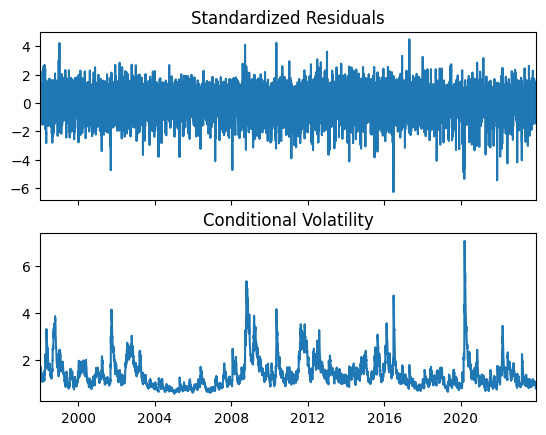

In [28]:
garch_result.plot();

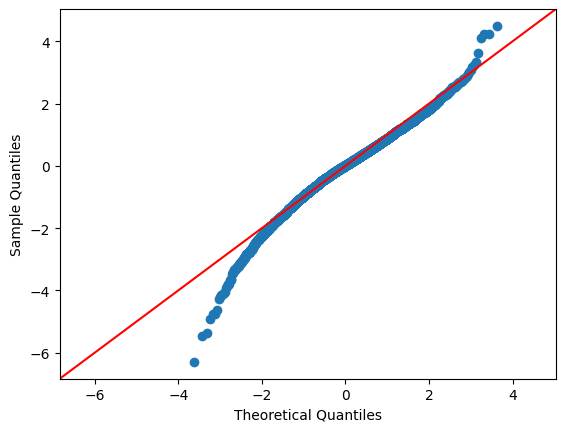

In [43]:
qqplot(garch_result.std_resid, line='45');

# COMMENTS:
# Presence of really fat left tail. This asymmetry should be modeled by specifying a different distribution on the assumption of residuals. 

##### Model validation

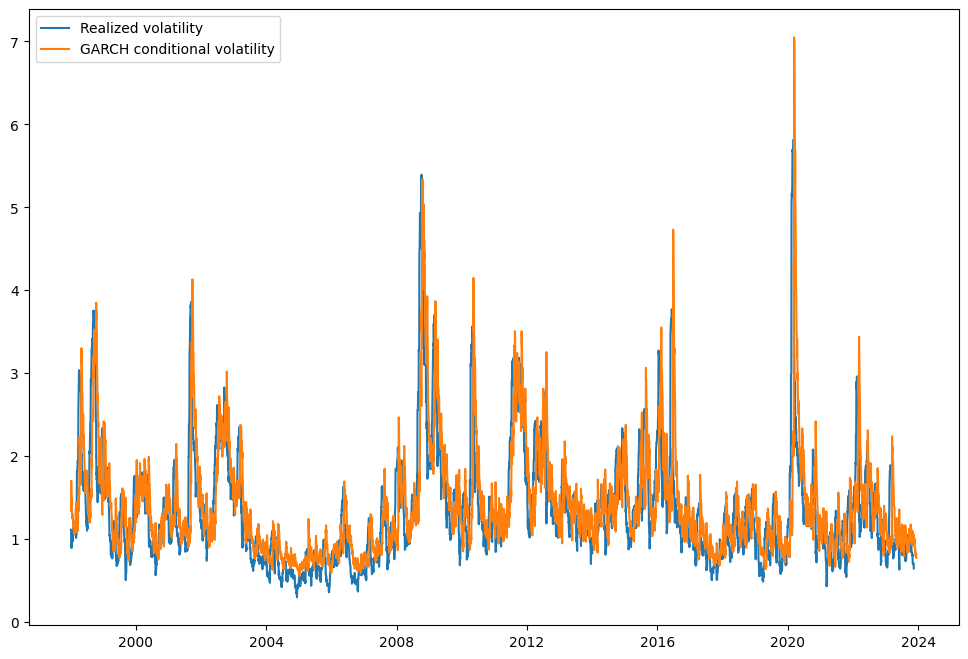

In [87]:
plt.figure(figsize=(12, 8))

plt.plot(realized_vol, label='Realized volatility')

plt.plot(garch_result.conditional_volatility, label='GARCH conditional volatility')
plt.legend()

## Modeling of asymmetric responses of volatility


#### Leverage effect

Leverage effect is one characertistics of the volatility that seems to react differently to a big price increase or a big price drop.

- Debt-equity Ratio = Debt / Equity
- Stock price goes down, debt-equity ratio goes up
- Riskier!

GARCH models assume that positive and negative news have a symmetric impact on the volatility of the returns. However, we know that markets tend to have an asymmetric response to positive events and negative events. Negative events (in finance, these are called Black Swans) have a significantly larger impact on the returns in the market and consequently on the volatility. 

There are two extensions of the GARCH model that allows to better capture the asymmetric behaviour of the volatility: EGARCH and GJR-GARCH. 




#### News Impact Curve

## Evaluate and compare the models

In [ ]:
# models : dictionary with key the name of the model and value the forecast of the model (or the fit)
# realized : the observed daily volatilities
def evaluate(models : dict, realized): 

    results_df = {}

    for forecast in models.values():

        # Call sklearn function to calculate MAE
        results_df['MAE'] = mean_absolute_error(realized, forecast)

        # Call sklearn function to calculate MSE
        results_df['MSE'] = mean_squared_error(realized, forecast)


    results_df = pd.DataFrame(results_df, index = models.keys())

    return results_df

In [89]:
# Backtest model with MAE, MSE
models = {'GARCH(1,1)' : garch_result.conditional_volatility.values[:-21]}
evaluate(models, realized_vol)

,MAE,MSE
"GARCH(1,1)",0.384701,0.336684


### CREATING CUSTOM FUNCTIONS FOR LATER USE

All this functions are going to be stored in the `utils.py` file, so that we can build a sort of library for this project. 

#### VOLATILITY ESTIMATORS

- **GARMAN KLASS FORMULA** (From the original paper)
    $$ \sigma_i = 0.511(u - d)^2 - 0.019\big[c(u + d) - 2ud \big]-0.383c^2$$  

    where:

    - $u = \log{\text{High}} - \log{\text{Open}}$
    - $d = \log{\text{Low}} - \log{\text{Open}}$
    - $c = \log{\text{Close}} - \log{\text{Open}}$

    and: 
    - $Open$ is the opening price on the considered day
    - $Close$ is the closing price on the considered day
    - $Low$ is the lowest price reached on the considered day
    - $High$ is the highest price peaked on the considered day
